## Evolving the scientist journal game with paramless

In [26]:
include("src/journal_paramless.jl")
using Plots;

We attempt to evolve a submission set in tandem with a journal. The submission set takes values from $[0,1]$ and returns $1$ for submission and $0$ for no submission. The journal evolves parameters $\epsilon$ and $q_t$. $\epsilon$ controls the strictness of the filter in accepting journals, but drives up the cost to the journal, and $q_t$ is the threshold quality for submission. 

In [23]:
domain = Array(range(0.0,1.0, length=100));
resident_sub = 0.01*ones(size(domain)); # 0.0, not 0, everyone submits with pr 0
resident_eps = 0.0
resident_qt = 0.0

0.0

Note that the format below is mandatory, all keyword arguments are used at some point. To use rejection, add quality=false as a keyword argument. We use the parameters:
- $10^5$ iterations
- $k=8.0$
- $c=0.6$
- journal mutation,mutation epsilon $10^{-2}$
- width $10^{-1}$
- quality = true
- version = 3

In [28]:
result_dict = co_evolve(domain, resident_sub, resident_eps, resident_qt,
1e5, 1e-9, 0, 1e3; k=8.0, 
c= 0.6, mutation_epsilon=0.001,mutation_epsilon_journal=0.001, 
lower_bound=0.0, upper_bound=1.0, 
width=0.01, quality=true, version=3);


In [29]:
result_dict

Dict{String, Any} with 6 entries:
  "time_series_q_threshold" => [[0.0, 0.0], [1000.0, 0.489], [2000.0, 0.978], […
  "time_series_submission"  => Vector{Any}[[0, [0.01, 0.01, 0.01, 0.01, 0.01, 0…
  "resident_q_threshold"    => 0.999
  "resident_ϵ"              => 0.71
  "time_series_ϵ"           => [[0.0, 0.0], [1000.0, 0.498], [2000.0, 0.395], […
  "resident_submission"     => [0.0293475, 0.0322671, 0.0350297, 0.0374302, 0.0…

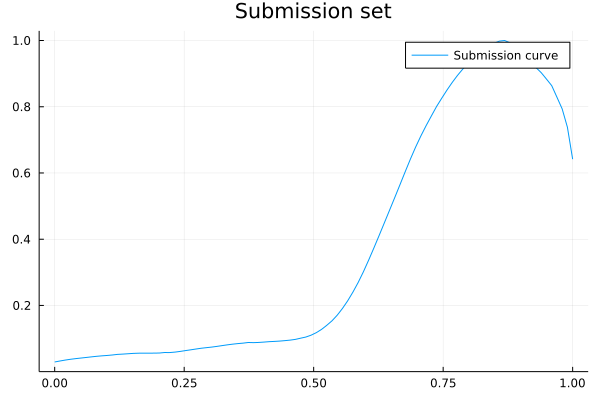

In [30]:
plot(domain, result_dict["resident_submission"], title="Submission set", label = "Submission curve")

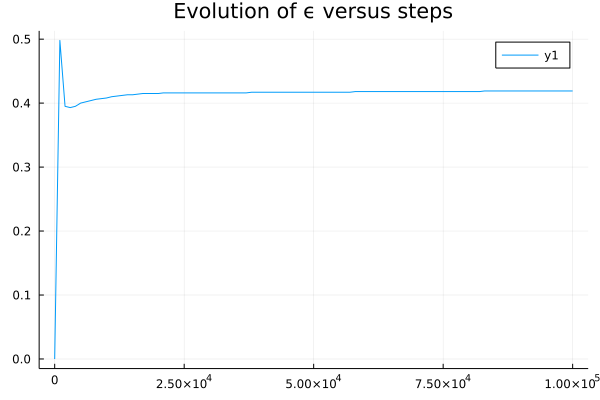

In [37]:
    plot(map((x) -> x[1], result_dict["time_series_ϵ"]),map((x) -> x[2], result_dict["time_series_ϵ"]), title = "Evolution of ϵ versus steps")

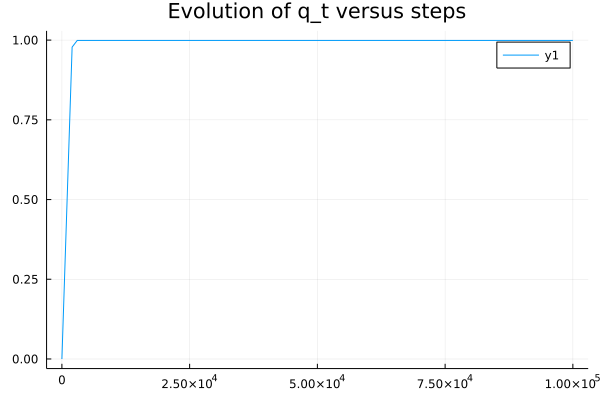

In [7]:
plot(map((x) -> x[1], result_dict["time_series_q_threshold"]),map((x) -> x[2], result_dict["time_series_q_threshold"]), title = "Evolution of q_t versus steps")

- $10^5$ iterations
- $k=8.0$
- $c=0.6$
- journal mutation,mutation epsilon $10^{-2}$
- width $10^{-1}$
- quality = true
- version = 3

In [6]:
result_dict = co_evolve(domain, resident_sub, resident_eps, resident_qt,
2e5, 1e-9, 777; k=8.0, 
c= .8, mutation_epsilon=0.001,mutation_epsilon_journal=0.01, 
lower_bound=0.0, upper_bound=1.0, 
width=0.01, quality=true, version=3, snapshot_iter=1e2);

In [7]:
result_dict

Dict{String, Any} with 6 entries:
  "time_series_q_threshold" => [[0.0, 0.0], [100.0, 0.54], [200.0, 0.99], [300.…
  "time_series_submission"  => Vector{Any}[[0, [0.01, 0.01, 0.01, 0.01, 0.01, 0…
  "resident_q_threshold"    => 0.99
  "resident_ϵ"              => 0.97
  "time_series_ϵ"           => [[0.0, 0.0], [100.0, 0.5], [200.0, 0.34], [300.0…
  "resident_submission"     => [0.0117055, 0.0119932, 0.0123025, 0.012631, 0.01…

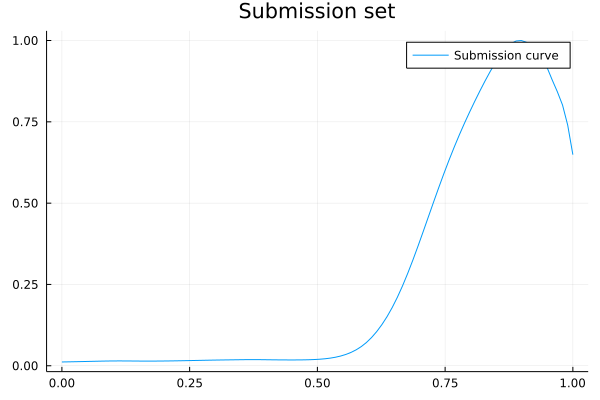

In [8]:
plot(domain, result_dict["resident_submission"], title="Submission set", label = "Submission curve")

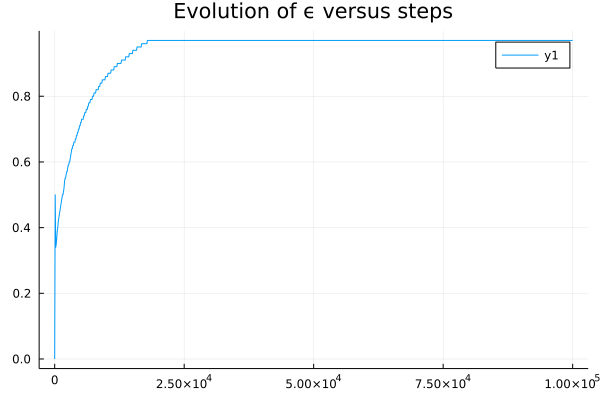

In [14]:
plot(map((x) -> x[1], result_dict["time_series_ϵ"]),map((x) -> x[2], result_dict["time_series_ϵ"]), title = "Evolution of ϵ versus steps")

In [9]:
result_dict = co_evolve(domain, resident_sub, resident_eps, resident_qt,
1e6, 1e-9, 777; k=8.0, 
c= .5, mutation_epsilon=0.001,mutation_epsilon_journal=0.001, 
lower_bound=0.0, upper_bound=1.0, 
width=0.01, quality=true, version=3, snapshot_iter=1e2);

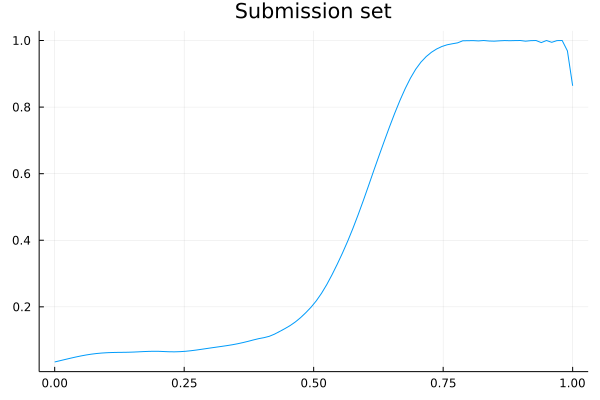

In [10]:
plot(domain, result_dict["resident_submission"], title="Submission set", label="")

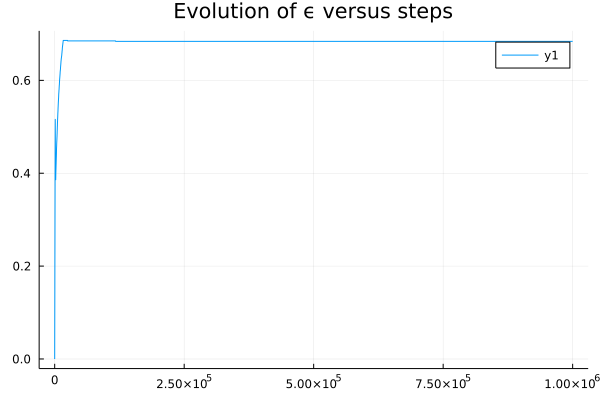

In [11]:
plot(map((x) -> x[1], result_dict["time_series_ϵ"]),map((x) -> x[2], result_dict["time_series_ϵ"]), title = "Evolution of ϵ versus steps")

In [7]:
result_dict # Evolve a probability function, vector_valeud= true return q_t,

Dict{String, Any} with 6 entries:
  "time_series_q_threshold" => [[0.0, 0.0], [100.0, 0.0054], [200.0, 0.0102], […
  "time_series_submission"  => Vector{Any}[[0, [0.01, 0.01, 0.01, 0.01, 0.01, 0…
  "resident_q_threshold"    => 1.0
  "resident_ϵ"              => 0.3679
  "time_series_ϵ"           => [[0.0, 0.0], [100.0, 0.0053], [200.0, 0.0101], […
  "resident_submission"     => [0.215002, 0.246498, 0.277035, 0.306195, 0.33397…